# Exploring Unsupervised Methods 

Documenting progress & observations below.

Methods:
- **K-means**: Identifies patterns via clustering

  - ADV: 

  - DISADV: can be skewed by outliers (via usage of mean), must chose k

- **DBSCAN**: Identifies patterns via use of a minimum radius and sequential clustering

  - ADV: avoids heavy influence by outliers, good for ds with many features

  - DISADV: heavily influenced by choice of radius + peers

- **PCA**: Reduce dimensionality of ds by identifying the most varying features

  - ADV: reducing computational power expense

  - DISADV: reduction in accuracy

  - OTHER: can be used in conjunction with other methods

Importing Libraries

In [6]:
from TelescopeML.StatVisAnalyzer import *
from TelescopeML.DataMaster import *
from TelescopeML.Predictor import *
import os 

Loading BokehJS ...

Loading BokehJS ...

1. Processing Data (pulled from existing notebooks)

In [7]:
# obtain data
__reference_data_path__ = os.getenv("TelescopeML_reference_data")
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 'training_datasets', 'browndwarf_R100_v4_newWL_v3.csv.bz2'), compression='bz2')

output_names = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
wavelength_names = [item for item in train_BD.columns.to_list() if item not in output_names]
wavelength_values = [float(item) for item in wavelength_names]

# initialize i/o for model
X = train_BD.drop(columns=output_names)
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]

data_processor = DataProcessor( 
    flux_values=X.to_numpy(),
    wavelength_names=X.columns,
    wavelength_values=wavelength_values,
    output_values=y.to_numpy(),
    output_names=output_names,
    spectral_resolution=200,
    trained_ML_model=None,
    trained_ML_model_name='CNN',
)

data_processor.split_train_validation_test(test_size=0.1, 
    val_size=0.1, 
    random_state_=42,)

# standardize rows and columns
data_processor.standardize_X_row_wise() 
data_processor.standardize_y_column_wise()               

2. Feature Engineering (Take Min and Max of each row)

In [8]:
# train
data_processor.X_train_min = data_processor.X_train.min(axis=1)
data_processor.X_train_max = data_processor.X_train.max(axis=1)

# validation
data_processor.X_val_min = data_processor.X_val.min(axis=1)
data_processor.X_val_max = data_processor.X_val.max(axis=1)

# test
data_processor.X_test_min = data_processor.X_test.min(axis=1)
data_processor.X_test_max = data_processor.X_test.max(axis=1)

df_MinMax_train = pd.DataFrame((data_processor.X_train_min, data_processor.X_train_max)).T
df_MinMax_val = pd.DataFrame((data_processor.X_val_min, data_processor.X_val_max)).T
df_MinMax_test = pd.DataFrame((data_processor.X_test_min, data_processor.X_test_max)).T

df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_val.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_test.rename(columns={0:'min', 1:'max'}, inplace=True)

data_processor.standardize_X_column_wise(
    output_indicator='Trained_StandardScaler_X_ColWise_MinMax',
    X_train = df_MinMax_train.to_numpy(),
    X_val   = df_MinMax_val.to_numpy(),
    X_test  = df_MinMax_test.to_numpy(),
    )

In [11]:
help(data_processor.standardize_y_column_wise)

Help on method standardize_y_column_wise in module TelescopeML.DataMaster:

standardize_y_column_wise(output_indicator='Trained_StandardScaler_y_ColWise', y_train=None, y_val=None, y_test=None, print_model=False) method of TelescopeML.DataMaster.DataProcessor instance
    Standardize target variable (y) column-wise by removing the mean and scaling to unit variance.
    Transform the data such that its distribution will have a mean value of 0 and a standard deviation of 1.
    
    Parameters
    -----------
    y_train : array
        Training target variable array.
    y_val : array
        Validation target variable array.
    y_test : array
        Test target variable array.
    print_model : bool
        Whether to print the trained scaler model.
    
    Returns
    -------
    self.y_train_standardized_columnwise : array
        Standardized training target variable array.
    self.y_val_standardized_columnwise : array
        Standardized validation target variable array.
    s

K-means

In [14]:
from sklearn.cluster import KMeans
import pandas as pd
from UnsupervisedDeepTrainer import * # change later perhaps
x_vals = np.array(data_processor.X_train_standardized_rowwise)
ap    = data_processor.y_train_standardized_columnwise
df = pd.DataFrame(x_vals)

In [1]:
def build_1d_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # 1D CNN Layers for feature extraction
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    return inputs, x

In [2]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    
    # Skip connection
    x = tf.keras.layers.Add()([x, inputs])

    # Feed Forward part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    
    # Skip connection
    return tf.keras.layers.Add()([x, inputs])

In [4]:
def build_cnn_transformer_model(input_shape):
    # CNN Feature Extraction
    cnn_inputs, cnn_features = build_1d_cnn(input_shape)
    
    # Apply Transformer Encoder on the extracted features
    transformer_out = transformer_encoder(cnn_features, head_size=128, num_heads=4, ff_dim=128)
    
    # Global average pooling to reduce to a single vector
    x = tf.keras.layers.GlobalAveragePooling1D()(transformer_out)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Output Layer (for multi-output regression, 3 continuous outputs)
    outputs = tf.keras.layers.Dense(4)(x)
    
    return tf.keras.Model(inputs=cnn_inputs, outputs=outputs)

In [17]:
input_shape = data_processor.X_train_standardized_rowwise.shape # Shape of the data (timesteps, features)


model = build_cnn_transformer_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    x_vals, data_processor.y_train_standardized_rowwise,
    validation_data=(data_processor.X_val_standardized_rowwise, data_processor.y_val_standardized_columnwise),
    epochs=10,  # Adjust the number of epochs as needed
    batch_size=32
)

# Step 6: Evaluate the Model
test_loss, test_mae = model.evaluate(data_processor.X_test_standardized_columnwise, data_processor.y_test_standardized_columnwise)

[[-0.32920785 -0.52073614]
 [-0.3292212  -0.53116191]
 [ 0.11247685  2.0810484 ]
 ...
 [-0.32921541 -0.49945557]
 [-0.32922059 -0.52866692]
 [-0.3292212  -0.5309106 ]]
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 25019, 2)]           0         []                            
                                                                                                  
 conv1d_13 (Conv1D)          (None, 25019, 64)            448       ['input_5[0][0]']             
                                                                                                  
 conv1d_14 (Conv1D)          (None, 25019, 128)           24704     ['conv1d_13[0][0]']           
                                                                                                  
 max_pooling1d_3 (MaxPo

ValueError: in user code:

    File "c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 25019, 2), found shape=(None, 104)


In [5]:
# um = UnsupervisedML(x_vals[:5000])
# history, res = um.build_and_train_model(epochs=1)


In [7]:
# plt.plot(history.history['loss'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.show()


In [6]:
# from UnsupervisedDeepTrainer import reshape_x
# feat = res.predict(reshape_x(x_vals[:5000],4))

1/1 [==============================] - 0s 121ms/step


In [6]:
# two_d = np.reshape(feat, (feat.shape[1],feat.shape[2]))
# labels = um.kmeans(features=two_d)

# print(labels)



In [7]:
model = UnsupervisedML(x_vals)
# labels = model.kmeans()
db_labels = model.DBscan(0.3)


In [9]:

def plot_clusters(
        cluster_alg, 
        labels, # column of cluster labels
        df, # df of wavelengths
        ap=[], # atmospheric parameters
        xvar="c_o_ratio",
        yvar="temperature"
    ):
    """Plots clusters with respect to different variables."""
    if len(ap != 0):
        df['gravity'] = ap[:,[0]]
        df['c_o_ratio'] = ap[:,[1]]
        df['metallicity'] = ap[:,[2]]
        df['temperature'] = ap[:,[3]]

    if cluster_alg == "kmeans":
        kmeans_df = df
        kmeans_df['kmeans'] = labels
        fig, ax = plt.subplots()
        ax.set_title('Kmeans Clusters')
        ax.scatter(x=kmeans_df[xvar],y=kmeans_df[yvar],c=kmeans_df['kmeans'])
        ax.gca().update(dict(title=f'{xvar} vs {yvar}', xlabel=xvar, ylabel=yvar))
        ax.legend()
        return [fig,ax]

    if cluster_alg == "dbscan":
        dbscan_df = df
        dbscan_df['dbscan'] = labels
        plt.scatter(x=dbscan_df[xvar],y=dbscan_df[yvar],c=dbscan_df['dbscan'])
        plt.gca().update(dict(title=f'{xvar} vs {yvar}', xlabel=xvar, ylabel=yvar))
        plt.colorbar()
        plt.show()
        return
    print("Enter kmeans or dbscan as an option to plot.")


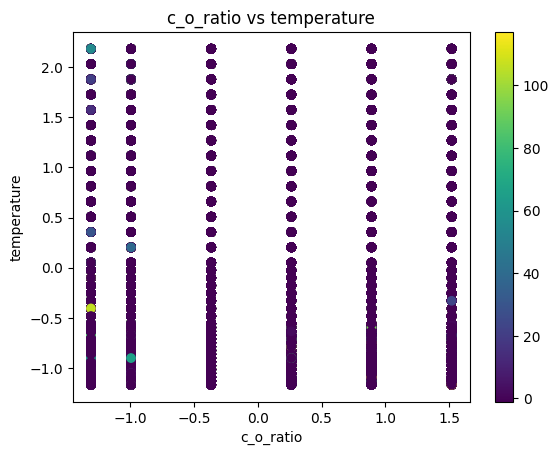

In [12]:
plot_clusters("dbscan", db_labels, df, ap, "c_o_ratio", "temperature")

In [8]:
x_vals = x_vals[:-1] # make even --> randomly drop


# References

Used for understanding purpose and background of TelescopeML:

- https://github.com/EhsanGharibNezhad/TelescopeML
- Gharib-Nezhad et al. (2024). TelescopeML – I. An End-to-End Python Package for Interpreting Telescope Datasets through Training
Machine Learning Models, Generating Statistical Reports, and Visualizing Results’ Journal of Open Source Software, 9(99), 6588. https:
//doi.org/10.21105/joss.06346.

Other Resources Consulted: 
- Streamlit Tutorial https://www.youtube.com/watch?v=D0D4Pa22iG0&t=41s 
- K-Means Tutorial https://www.youtube.com/watch?v=iNlZ3IU5Ffw&pp=ygUWa21lYW5zIHR1dG9yaWFsIHB5dGhvbg%3D%3D 
- DBSCAN Tutorial https://www.youtube.com/watch?v=2eDFjw456AM 
- PCA Tutorial https://www.youtube.com/watch?v=8klqIM9UvAc&pp=ygUScGNhdHV0b3JpYWwgcHl0aG9u
- CNN - K-means model mix https://arxiv.org/pdf/1906.03359 
- CNN & K-means Algorithm descriptors https://www.cs.rice.edu/~as143/COMP642_Spring22/Scribes/Lect15 
- Autoencoder Theory Explanation https://www.youtube.com/watch?v=qUf_pJ4OHH0 
- Keras Documentation https://keras.io/api/layers/pooling_layers/max_pooling2d/ 
- Tensorflow Documentation https://www.tensorflow.org/api_docs/python/tf 
- Streamlit Documentation https://docs.streamlit.io/
- Unsupervised Classification https://www.aanda.org/articles/aa/full_html/2018/04/aa32134-17/aa32134-17.html 